In [5]:
import sys
import numpy as np
import sys
print(sys.version)

from phasor.utilities.ipynb.displays import *

import declarative
from phasor import alm
from phasor.alm.mplot import MPlotter

mplot = MPlotter()
asavefig.org_subfolder = 'gtable'

3.5.3 (default, May 10 2017, 15:05:55) 
[GCC 6.3.1 20161221 (Red Hat 6.3.1-1)]


/home/mcculler/local/home_sync/projects/phasor/phasor/alm/beam_fit.py:58: RuntimeWarning: invalid value encountered in sqrt
  return (self.wavelen_nm * 1e-9 / (np.pi * z_R) * ((z + z_0)**2 + z_R**2))**.5


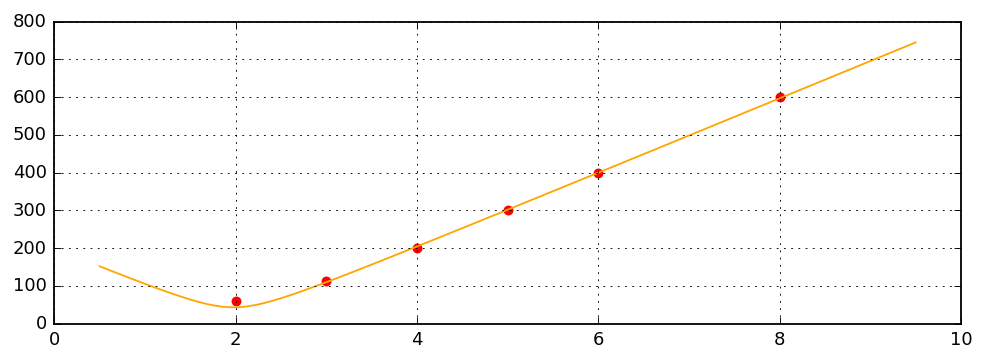

In [6]:
q_PBS = alm.QFit(                                                             
            wavelen_nm = 532.,                                                      
            R_um = np.array([1200, 800, 400, 225, 120, 600]) / 2,                                   
            Z_in = [8, 6, 4, 3, 2, 5],                                                          
        )  
axB = q_PBS.plot()

In [7]:
sys = alm.RootSystem( )

sys.own.q_in = alm.BeamTarget(loc_in = 0, q_raw = q_PBS.q_fit)
sys.own.L1 = alm.ThinLens(loc_in = 6, f_mm = 100)
sys.own.q_out = alm.BeamTarget(loc_in = 19, q_raw = alm.ComplexBeamParam.from_Z_W0(0, 450e-6))

ax = mplot.plot('to_fiber', sys.measurements)
sys.measurements.q_target_z(1.42).value
sys.measurements.overlap_seq()

figure: gtable/to_fiber.png
[[file:gtable/to_fiber.png]]


0.93191406864219639

In [8]:
import phasor.fitting.casadi as FIT

fitter = FIT.FitterRoot()
fitter.own.sym = FIT.FitterSym()
fitter.systems.alm = sys
fitter.sym.parameter(sys.L1.loc_in)
fitter.sym.parameter(sys.q_out.loc_in)

def objective(alm):
    return abs(alm.measurements.overlap('q_in', 'q_out'))**4
print("HEY: ", objective(sys))
fitter.own.overlap = FIT.FitterExpression(
    function = objective,
)
ret = fitter.overlap.minimize_function()
print("OVERLAP: ", objective(ret.systems.alm))
ax = mplot.plot('quickfit', ret.systems.alm.measurements)

HEY:  0.931914068642
Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  -1.0000000000000009e+00   -1.0000000000000009e+00
Dual infeasibility......:   7.5663612805258110e-16    7.5663612805258110e-16
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090923e-17    9.09090909090909

In [ ]:

class QTest(alm.System):
    @declarative.dproperty
    def q_in(self):
        return alm.BeamTarget(loc_in = 0, q_raw = q_PBS.q_fit)
    @declarative.dproperty
    def L1(self):
        return alm.ThinLens(loc_in = 6, f_mm = 100)
    @declarative.dproperty
    def q_out(self):
        return alm.BeamTarget(loc_in = 19, q_raw = alm.ComplexBeamParam.from_Z_W0(0, 450e-6))

sys = alm.RootSystem( )
sys.own.test = QTest(loc_in = 0)
ax = mplot.plot('to_fiber', sys.measurements)
sys.measurements.overlap_seq()